In [1]:
#| include: false
from IPython.display import HTML

Here's a video walkthrough of this notebook:

In [5]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/3g5YLK1nbu8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Introduction

In this notebook, I work through the first of four "Further Research" problems assigned at the end of Chapter 7 in the textbook "Deep Learning for Coders with fastai and PyTorch".

The prompt for this exercise is:

>Use the fastai documentation to build a function that crops an image to a square in each of the four corners; then implement a TTA method that averages the predictions on a center crop and those four crops. Did it help? Is it better than the TTA method of fastai?

## What is Test Time Augmentation?

I'll quote directly from the text:

>During inference or validation, creating multiple versions of each image using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

TTA is data augmentation during validation, in hopes that objects located outside the center of the image (which is the default fastai validation image crop) can be recognized by the model in order to increase the model's accuracy.

The default `Learner.tta` method averages the predictions on the center crop and four randomly generated crops. The method I'll create will average the predictions between the center crop and four corner crops.

![tta.png](tta.png)

## User-defined Test Time Augmentation

### Read and understand the [`Learner.tta`](https://github.com/fastai/fastai/blob/master/fastai/learner.py#L576) and [`RandomCrop`](https://github.com/fastai/fastai/blob/master/fastai/vision/augment.py#L164) source code

```python
def tta(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
    "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
    if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
    if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
    try:
        self(_before_epoch)
        with dl.dataset.set_split_idx(0), self.no_mbar():
            if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
            aug_preds = []
            for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                aug_preds.append(self.get_preds(dl=dl, inner=True)[0][None])
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
        self.epoch = n
        with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(dl=dl, inner=True)
    finally: self(event.after_fit)

    if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
    preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
    return preds,targs

```

```python
class RandomCrop(RandTransform):
    "Randomly crop an image to `size`"
    split_idx,order = None,1
    def __init__(self, size, **kwargs):
        size = _process_sz(size)
        store_attr()
        super().__init__(**kwargs)

    def before_call(self, b, split_idx):
        self.orig_sz = _get_sz(b)
        if split_idx: self.tl = (self.orig_sz-self.size)//2
        else:
            wd = self.orig_sz[0] - self.size[0]
            hd = self.orig_sz[1] - self.size[1]
            w_rand = (wd, -1) if wd < 0 else (0, wd)
            h_rand = (hd, -1) if hd < 0 else (0, hd)
            self.tl = fastuple(random.randint(*w_rand), random.randint(*h_rand))

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        return x.crop_pad(self.size, self.tl, orig_sz=self.orig_sz)

```

In [ ]:
#| include: false
!pip install -Uqq fastai 
!pip install -Uqq fastcore

In [ ]:
#| include: false
import fastai
fastai.__version__=='2.3.1'

In [8]:
#| include: false
from fastai.vision.all import *

In [ ]:
#| include: false
from google.colab import drive
drive.mount('/content/gdrive')

### Practice cropping images using the `.crop` method on a `PILImage` object

A `PIL` `Image` has a method called `crop` which takes a crop rectangle tuple, `(left, upper, right, lower)` and crops the image within those pixel bounds.

Here's an image with a grizzly bear at the top and a black bear on the bottom. There are four coordinates of interest: left, upper, right and bottom. The leftmost points on the image are assigned a pixel value of 0. The rightmost points are located at the image width pixel pixel value. The uppermost points are at pixel 0, and the bottommost points are at the image height pixel value.

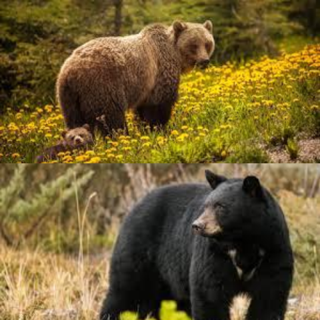

In [10]:
f = "/content/gdrive/MyDrive/fastai-course-v4/images/test/grizzly_black.png"
img = PILImage.create(f)
img.to_thumb(320)

#### Top-Left Corner Crop

A top-left corner crop the corresponds to a left pixel of 0, upper pixel 0, right pixel of 224, and bottom pixel of 224. The order in the tuple is left, upper, right, bottom, so 0, 0, 224, 224. You can see that this crop is taken from the top left corner of the original image.

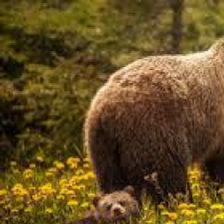

In [11]:
img.crop((0,0,224,224))

#### Top Right Corner Crop

For the top right corner, I get the image width since the left end of the crop will be 224 pixels from the right end of the image. That translates to w-224. The upper pixel is 0, and the rightmost pixel is at w, and the bottom pixel is 224. You can see that this crop is at the top right corner of the original.

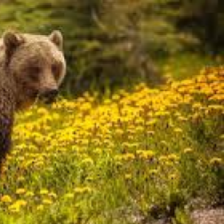

In [12]:
w = img.width
h = img.height
img.crop((w-224, 0, w, 224))

#### Bottom Right Corner Crop

For the bottom right corner the left pixel is 224 from the right end, w-224, the upper pixel is 224 from the bottom, h-224, the right pixel is at w, and the bottom is at h. 

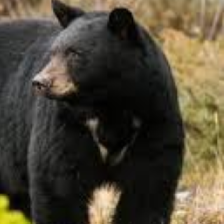

In [13]:
img.crop((w-224, h-224, w, h))

#### Bottom Left Corner Crop

The bottom left corner's leftmost pixel is 0, uppermost pixel is 224 pixels from the bottom of the whole image, h - 224, the rightmost pixel is 224, and bottommost pixel is the bottom of the whole image, at h.

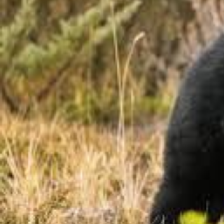

In [14]:
img.crop((0, h-224, 224, h))

#### Center Crop

Finally, for the center crop, the leftmost pixel is 112 left of the image center, w/2 - 112, the upper pixel is 112 above the image center, h/2 - 112, the rightmost pixel is 112 right of the center, w/2 + 112, and the bottom pixel is 112 below the center, h/2 + 112.

In [ ]:
img.crop((w/2-112, h/2-112, w/2+112,h/2+112))

#### Summary

To better visualize this, here are a couple of images which show the left, upper, right and bottom coordinates for the corner and center crops.

_Summary of corner `crop` arguments `(left, upper, right, bottom)`_



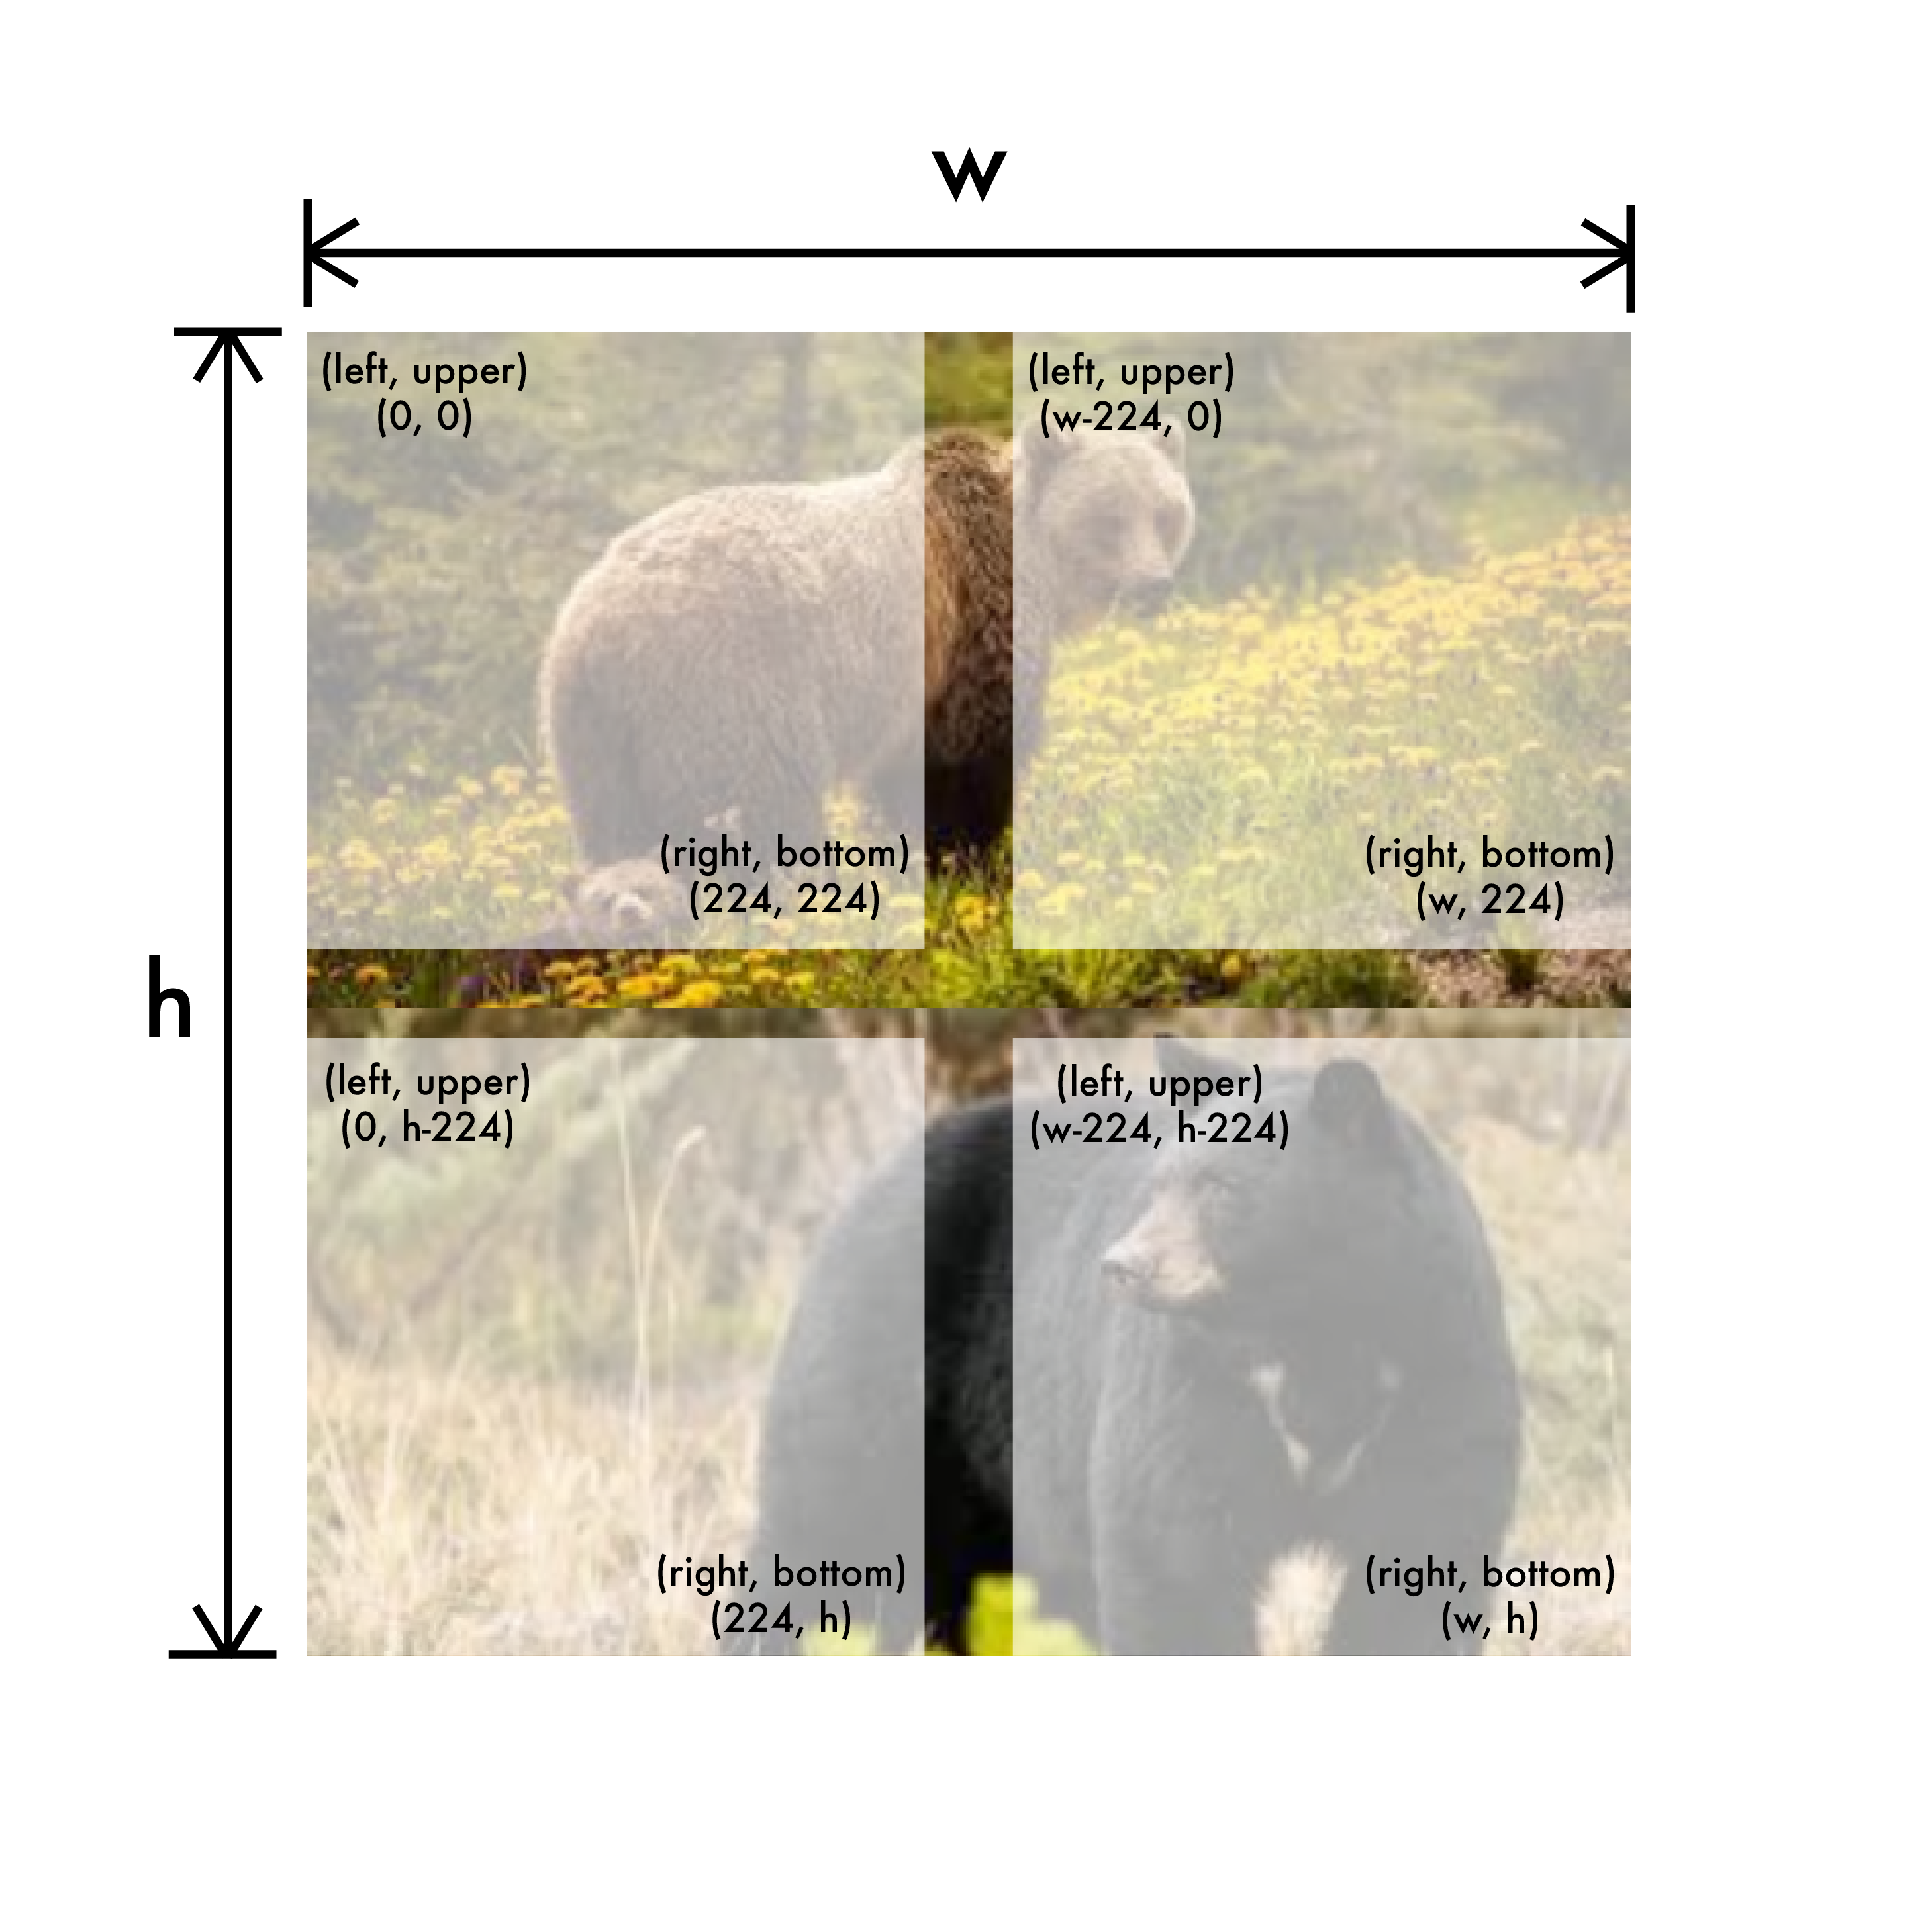

_Summary of center `crop` arguments `(left, upper, right, bottom)`_



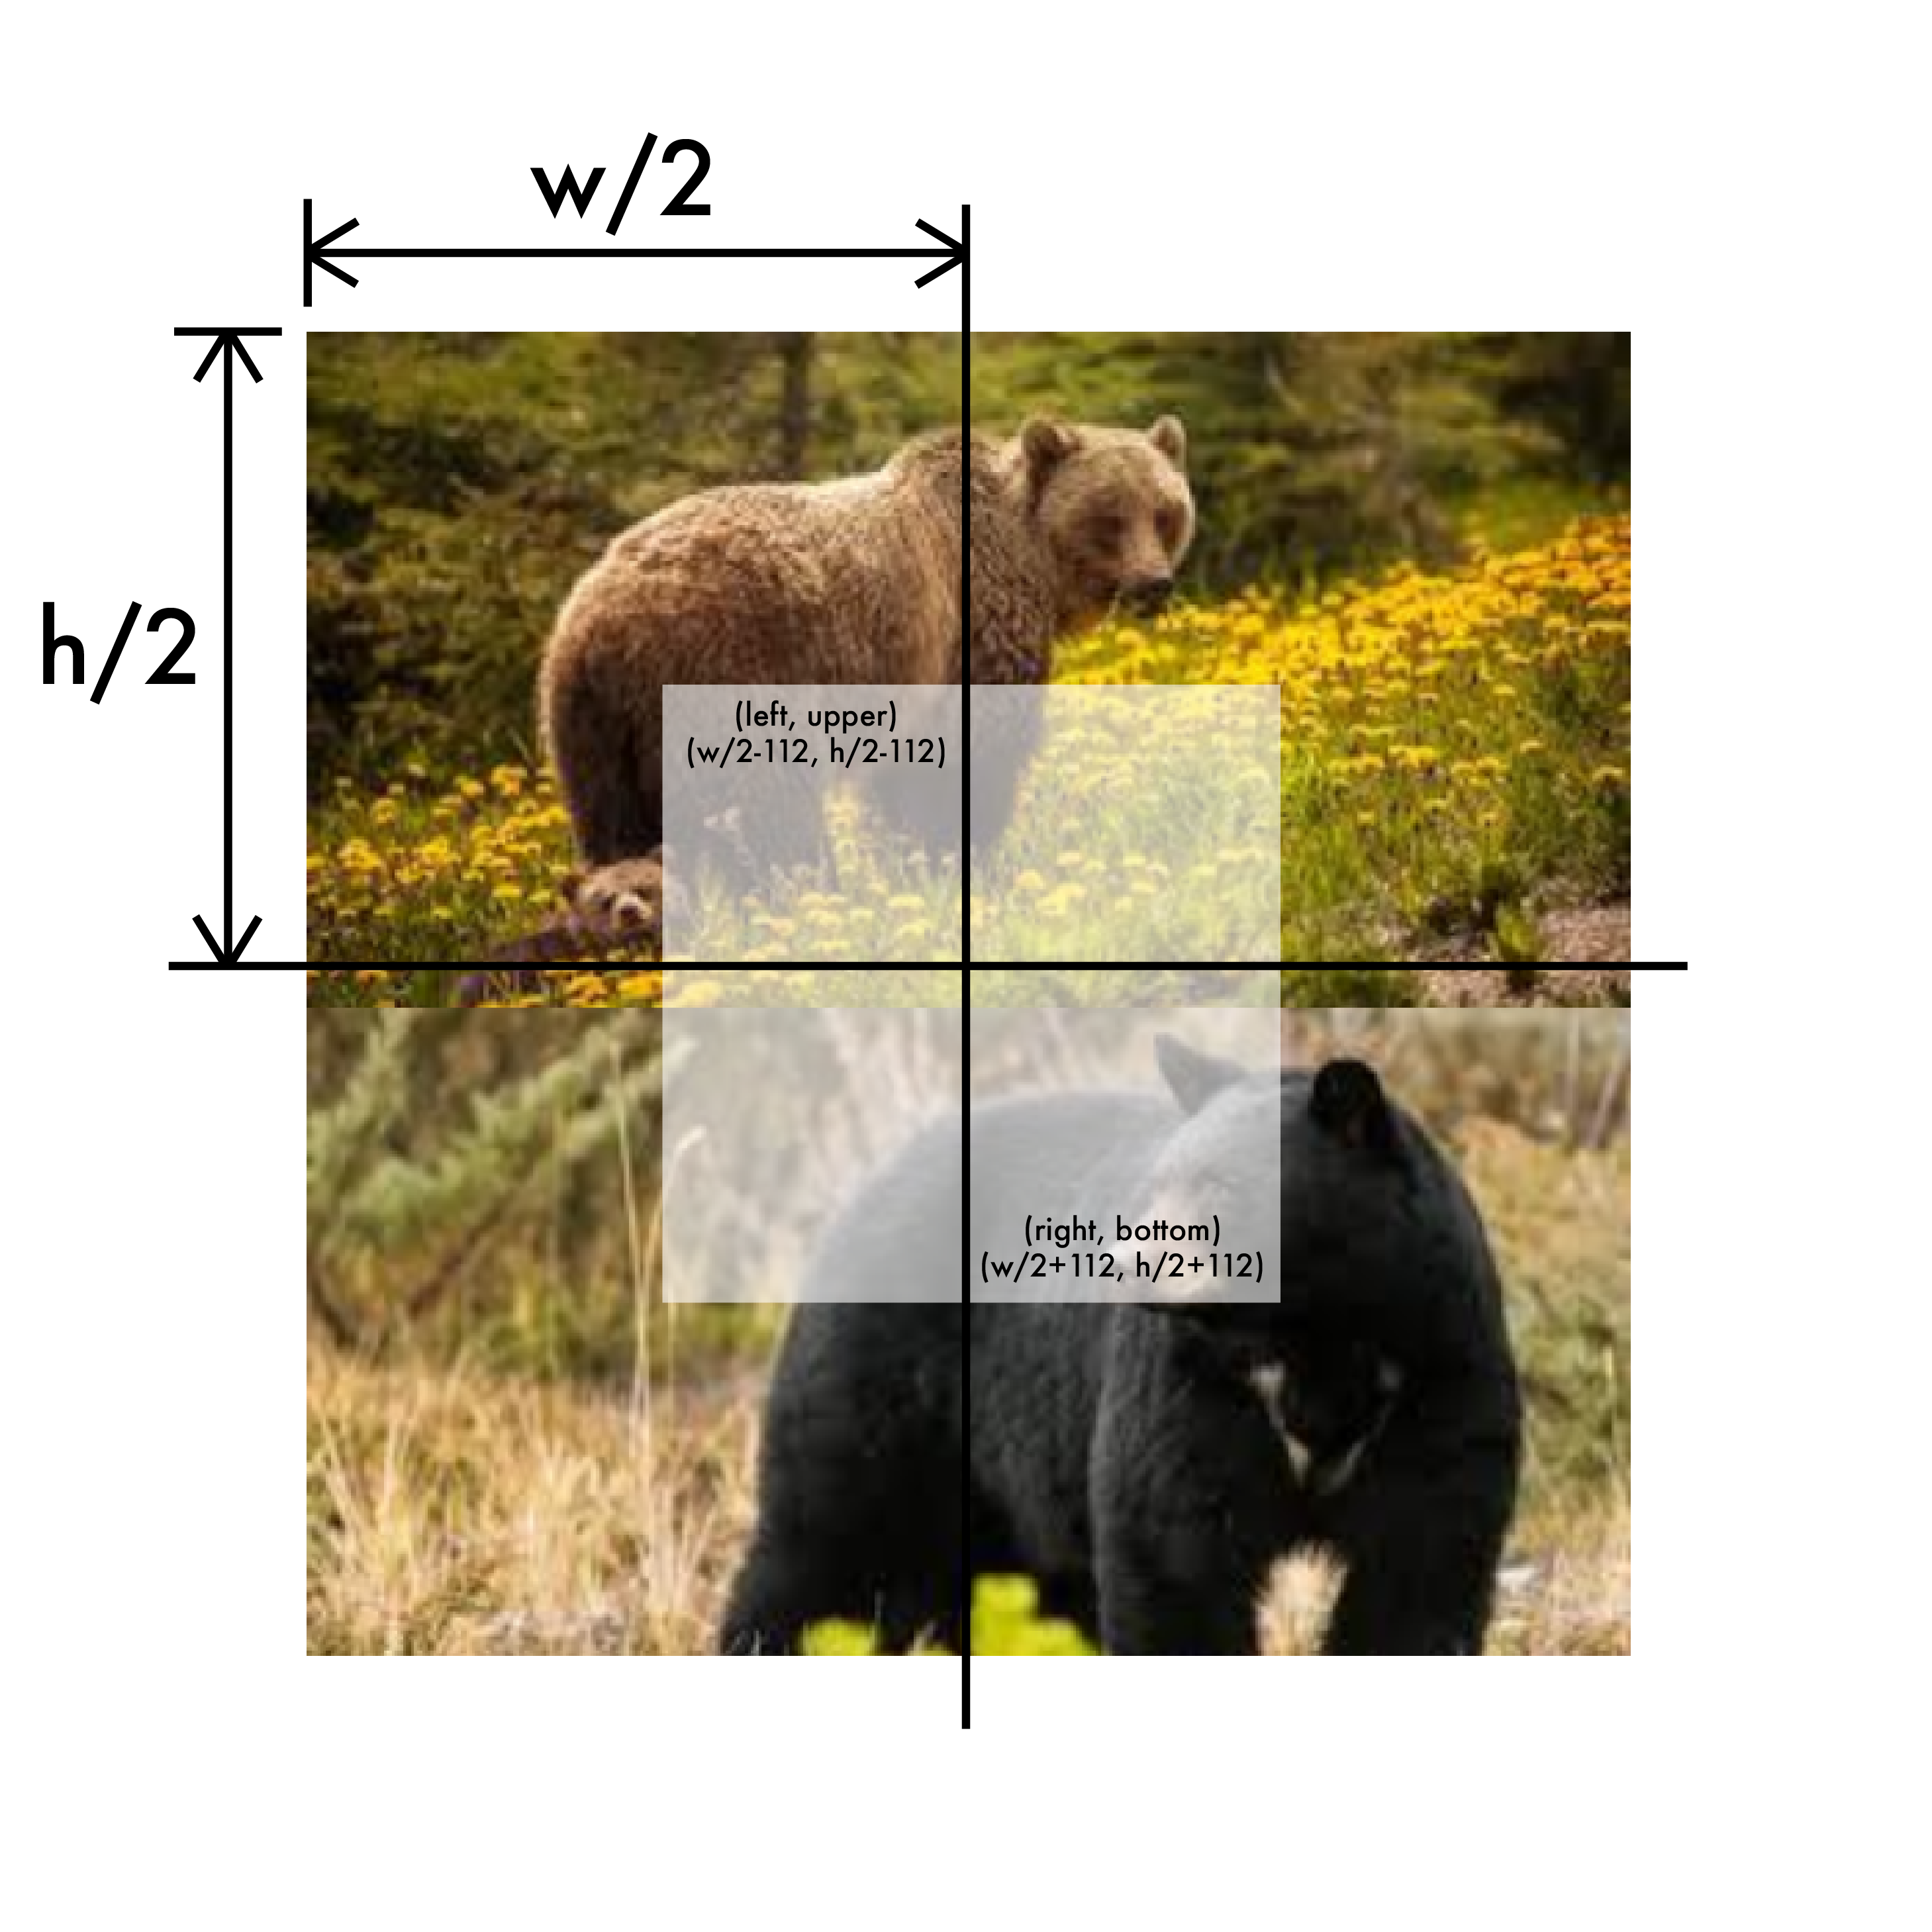

### Define a function which takes an image and returns a stacked `Tensor` with four corner crops and a center crop

I wrap those five lines of code into a function called corner_crop, which takes a PILImage img, and a square side length size (defaulted to 224) as its arguments. It first grabs the width and height of the image. And then goes on to save the crops of the four corners and center as TensorImages, returning them all in a single stacked Tensor.

In [16]:
def corner_crop(img, size=224):
  """Returns a Tensor with 5 cropped square images
  img: PILImage
  size: int
  """
  w,h = img.width, img.height
  top_left = TensorImage(img.crop((0,0,size,size)))
  top_right = TensorImage(img.crop((w-size, 0, w, size)))
  bottom_right = TensorImage(img.crop((w-size, h-size, w, h)))
  bottom_left = TensorImage(img.crop((0, h-size, size, h)))
  center = TensorImage(img.crop((w/2-size/2, h/2-size/2, w/2+size/2,h/2+size/2)))
  return torch.stack([top_left, top_right, bottom_right, bottom_left, center])

I'll test the corner_crop function and make sure that the five images are cropped correctly.

Here's the top left corner.

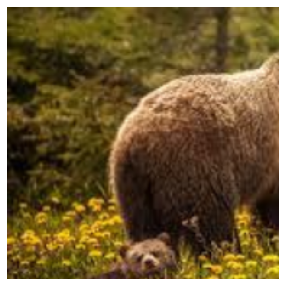

In [17]:
imgs = corner_crop(img)

# Top Left Corner Crop
imgs[0].show()

Top right corner:

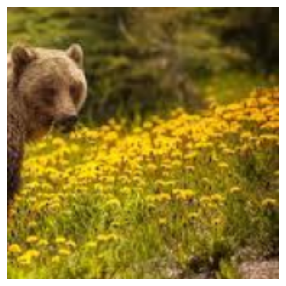

In [18]:
# Top Right Corner Crop
imgs[1].show()

Bottom right:

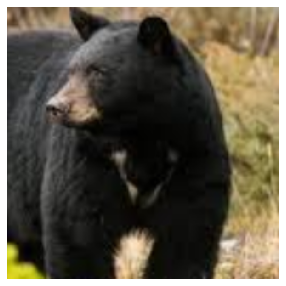

In [19]:
# Bottom Right Corner Crop
imgs[2].show()

Bottom left:

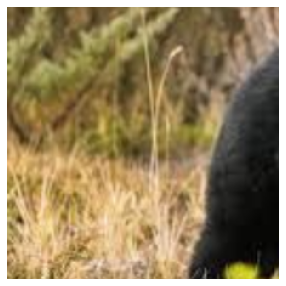

In [20]:
# Bottom Left Corner Crop
imgs[3].show()

And center:

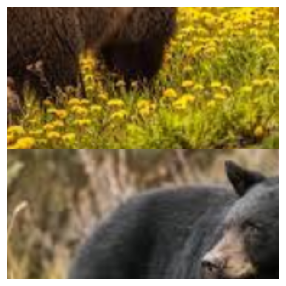

In [21]:
# Center Crop
imgs[4].show()

### Define a new `CornerCrop` transform by extending the `Transform` class definition

The main purpose for all of that was for me to wrap my head around how the crop behavior functions so that I can wrap that into a transform.

Transforms are any function that you want to apply to your data. I'll extend the base Transform class and add in the functionality I need for these crops. When an object of the `CornerCrop` class is constructed, the constructor takes size and `corner_type` arguments. Since I'll use this within a for-loop, the corner_type argument is an integer from `0` to `3`, corresponding to the loop counter. The transform is applied to the data during the `.encodes` method. I grab the original image `width` and `height`, and create a list of cropped images using the `left, upper, right, bottom` coordinates we saw above. Finally, based on the `corner_type`, the corresponding crop is returned.

In [22]:
class CornerCrop(Transform):
    "Create 4 corner and 1 center crop of `size`"
    def __init__(self, size, corner_type=0, **kwargs):
      self.size = size
      self.corner_type = corner_type

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
      self.w, self.h = x.size
      self.crops = [
                    x.crop((0,0,self.size, self.size)),
                    x.crop((self.w - self.size, 0, self.w, self.size)),
                    x.crop((self.w-self.size, self.h-self.size, self.w, self.h)),
                    x.crop((0, self.h-self.size, self.size, self.h))
                    ]
      return self.crops[self.corner_type]

To test this transform, I created an image with top left, top right, bottom right and bottom left identified. I created multiple copies so that I can create batches. 

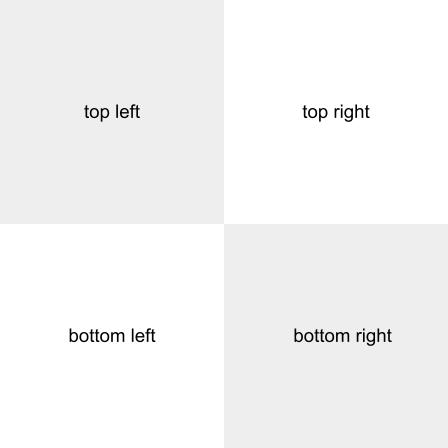

In [23]:
# test image for CornerCrop
path = Path('/content/gdrive/MyDrive/fastai-course-v4/images/test/corner_crop_images')
Image.open((path/'01.jpg'))

I create a DataBlock and pass my CornerCrop to the item_tfms parameter. I'll cycle through the different corner types. 0 corresponds to top left, 1 is top right, 2 is bottom right and 3 is bottom left. All images in my batch should be cropped to the same corner.

I set `corner_type` to `0`, build the DataBlock and DataLoaders and the batch shows top left.

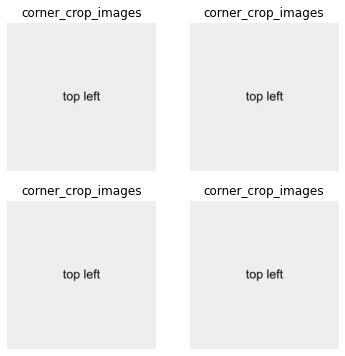

In [25]:
# get the data
# path = untar_data(URLs.IMAGENETTE)
path = Path('/content/gdrive/MyDrive/fastai-course-v4/images/test/corner_crop_images')

# build the DataBlock and DataLoaders using CornerCrop
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=CornerCrop(224,0))

dls = dblock.dataloaders(path, bs=4)

# view a batch
dls.show_batch()

I set `corner_type` to `1`, build the DataBlock and DataLoaders and the batch shows top right.

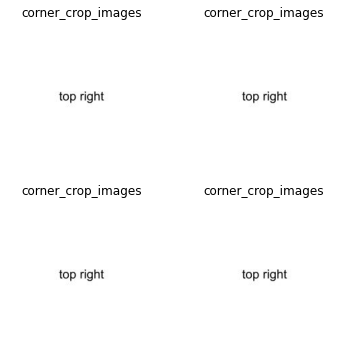

In [26]:
# build the DataBlock and DataLoaders using CornerCrop
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=CornerCrop(224,1))

dls = dblock.dataloaders(path, bs=4)

# view a batch
dls.show_batch()

I set `corner_type` to `2`, build the DataBlock and DataLoaders and the batch shows bottom right.

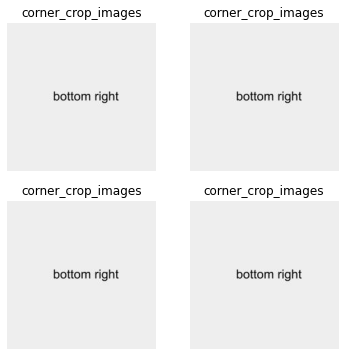

In [27]:
# build the DataBlock and DataLoaders using CornerCrop
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=CornerCrop(224,2))

dls = dblock.dataloaders(path, bs=4)

# view a batch
dls.show_batch()

I set `corner_type` to `3`, build the DataBlock and DataLoaders and the batch shows bottom left.

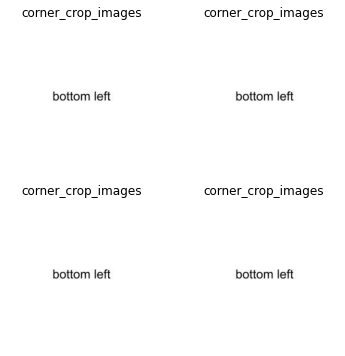

In [28]:
# build the DataBlock and DataLoaders using CornerCrop
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=CornerCrop(224,3))

dls = dblock.dataloaders(path, bs=4)

# view a batch
dls.show_batch()

Now, I can implement this transform into a new TTA method. 

### Define a new `Learner.corner_crop_tta` method by repurposing the existing `Learner.tta` definition

I'll largely rely on the definition of `tta` in the built-in `Learner` class. In this method, predictions are calculated on four sets of augmented data (images) and then averaged along with predictions on a center-crop dataset.

In the existing for-loop, four sets of predictions on randomly generated crops are appended into a list.

```python
for i in self.progress.mbar if hasattr(self,'progress') else range(n):
  self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
  aug_preds.append(self.get_preds(dl=dl, inner=True)[0][None])
```
In my loop, I create a new DataLoader each time, passing a different `corner_type` argument to the `CornerCrop` transform. I also have to pass the `ToTensor` transform, so that the PIL Image is converted to a Tensor. In the first iteration, it will append predictions on the top left corner crops. In the next one, it will append predictions on the top right, then the bottom right, and finally on the fourth loop, the bottom left.

```python
aug_preds = []
for i in range(4):
  dl = dls[1].new(after_item=[CornerCrop(224,i), ToTensor])
  #self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
  aug_preds.append(learn.get_preds(dl=dl, inner=True)[0][None])
  ```

Since I am to average these with the center-crop image predictions, I'll create a new `DataLoader` without the `CornerCrop` transform and calculate the predictions on those images:

```python
dl = dls[1].new(shuffled=False, drop_last=False)
with dl.dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dl, inner=True)
```

Finally, I'll append the center crop `preds` to `aug_preds` list, concatenate them into a single tensor and take the mean of the predictions:

```python
aug_preds.append(preds[None])
preds = torch.cat(aug_preds).mean(0)
```

I decided to create a new `Learner2` class which extends the built-in the `Learner`, and added the `corner_crop_tta` method by copying over the `tta` method, commenting out the lines I won't need and adding the lines and changes I've written above.

In [ ]:
class Learner2(Learner):
  def corner_crop_tta(self:Learner, ds_idx=1, dl=None, n=4, beta=0.25, use_max=False):
      "Return predictions on the `ds_idx` dataset or `dl` using Corner Crop Test Time Augmentation"
      if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
      # if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
      try:
          #self(_before_epoch)
          with dl.dataset.set_split_idx(0), self.no_mbar():
              if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
              aug_preds = []
              # Crop image from four corners
              for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                  dl = dl.new(after_item=[CornerCrop(224,i), ToTensor])
                  self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                  aug_preds.append(self.get_preds(dl=dl, inner=True)[0][None])
         # aug_preds = torch.cat(aug_preds)
         # aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
          self.epoch = n
          dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
          # Crop image from center
          with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(dl=dl, inner=True)
          aug_preds.append(preds[None])
      finally: self(event.after_fit)

     # if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
     # preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
     # preds = torch.cat([aug_preds, preds]).mean(0)
      preds = torch.cat(aug_preds).mean(0)
      return preds,targs

### Implement this new TTA method on the Imagenette classification model

In the last section of this notebook, I train a model on the Imagenette dataset, which a subset of the larger ImageNet dataset. Imagenette has 10 distinct classes.

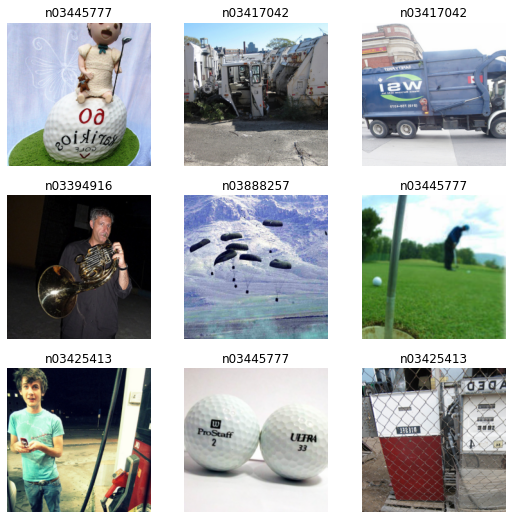

In [ ]:
# get the data
path = untar_data(URLs.IMAGENETTE)

# build the DataBlock and DataLoaders 
# for a single-label classification

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label, # image folder names are the class names
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = dblock.dataloaders(path, bs=64)

# view a batch
dls.show_batch()

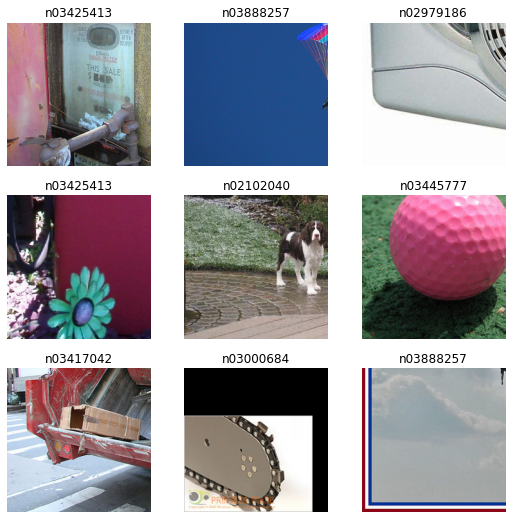

In [ ]:
# Try `CornerCrop` on a new DataLoader
# add `ToTensor` transform to conver PILImage to TensorImage
new_dl = dls[1].new(after_item=[CornerCrop(224,3), ToTensor])
new_dl.show_batch()

In [ ]:
# baseline training
model = xresnet50()
learn = Learner2(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

I run the default tta method, pass the predictions and targets to the accuracy function and calculate an accuracy of about 83.5% percent. Which is higher than the default center crop validation accuracy.

In [ ]:
# built-in TTA method
preds_tta, targs_tta = learn.tta()
accuracy(preds_tta, targs_tta).item()

0.8345780372619629

Finally, I run my new corner_crop_tta method, pass the predictions and targets to the accuracy function, and calculate an accuracy of about 70.9% percent. Which is lower than the default center crop validation accuracy.

In [ ]:
# user-defined TTA method
preds, targs = learn.corner_crop_tta()
accuracy(preds, targs).item()

0.7098581194877625

I'll walk through the `corner_crop_tta` code to verify the accuracy calculated above.

I first create an empty list for my augmented image predictions.

Then I loop through a range of 4, each time creating a new DataLoader which applies the `CornerCrop` transform for each corner type and append the predictions onto the list.

In [ ]:
# get predictions on corner cropped validation images
aug_preds = []
for i in range(4):
  dl = dls[1].new(after_item=[CornerCrop(224,i), ToTensor])
  #self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
  aug_preds.append(learn.get_preds(dl=dl, inner=True)[0][None])
len(aug_preds), aug_preds[0].shape

(4, torch.Size([1, 2678, 1000]))

I then create a new DataLoader without my transform, and get those predictions.

In [ ]:
# get predictions on center crop validation images
dl = dls[1].new(shuffled=False, drop_last=False)
with dl.dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dl, inner=True)
preds.shape

torch.Size([2678, 1000])

The shape of these predictions is missing an axis, so I pass None as a Key and it adds on a new axis.

In [ ]:
# add an axis to match augmented prediction tensor shape
preds = preds[None]
preds.shape

torch.Size([1, 2678, 1000])

I append the center crop predictions onto the augmented predictions and concatenate all five sets of predictions into a Tensor and calculate the mean.

In [ ]:
# average all 5 sets of predictions
aug_preds.append(preds)
preds = torch.cat(aug_preds).mean(0)

I then pass those average predictions and the targets to the accuracy function calculate the accuracy which is slightly higher than above. I ran these five cells multiple times and got the same accuracy value. When I ran the `corner_crop_tta` method multiple times, I got different accuracy values each time. Something in the `corner_crop_tta` definition is incorrect. I'll go with this value since it was consistent.

In [ ]:
# calculate validation set accuracy
accuracy(preds, targs).item()

0.7311426401138306

The following table summarize the results from this training:

|Validation|Accuracy|
|:-:|:-:|
|Center Crop|82.4%|
|Center Crop + 4 Random Crops: Linearly Interpolated|83.5%|
|Center Crop + 4 Random Crops: Averaged|73.1%|

There are a few further research items I should pursue in the future:

- Fix the `corner_crop_tta` method so that it returns the same accuracy each time it's run on the same trained model
- Try `corner_crop_tta` on a multi-label classification dataset such as PASCAL
- Try linear interpolation (between center crop and corner crop maximum) instead of mean